# DATA 620 - Assignment 5

Jeremy OBrien, Mael Illien, Vanita Thompson

* Choose a corpus of interest. 
* How many total unique words are in the corpus? (Please feel free to define unique words in any interesting, defensible way). 
* Taking the most common words, how many unique words represent half of the total words in the corpus
* Identify the 200 highest frequency words in this corpus. 
* Create a graph that shows the relative frequency of these 200 words. 
* Does the observed relative frequency of these words follow Zipf’s law? Explain.  
* In what ways do you think the frequency of the words in this corpus differ from “all words in all corpora.”  



## Setup

In [1]:
import pandas as pd
import nltk, re, pprint
import matplotlib.pyplot as plt
from tabulate import tabulate
from nltk import word_tokenize
from nltk.corpus import stopwords

## Data Import

We start by importing a corpora built into NLTK - Herman Melville's novel 'Moby Dick' (1851) - and exploring the data. Note that the raw text contains the entire book, including title, author and introductions. We will remove those sections to limit our analysis to the actual content of the book.

In [2]:
# Load the Moby Dick corpora from NLTK
path = nltk.data.find('corpora/gutenberg/melville-moby_dick.txt')
raw = open(path, 'r').read()

In [3]:
# Sift out prologue pages at beginning of corpora
raw_text = raw[21467:]

# Confirm starting point
raw_text[:100]

'Call me Ishmael.  Some years ago--never mind how long\nprecisely--having little or no money in my pur'

## Data Exploration and Analysis

We break down the raw text into tokens and filter out punctuation in order to focus on the words we'll analyze.

In [4]:
# Tokenize the corpus
tokens = word_tokenize(raw_text)
text = nltk.Text(tokens)
print('The text contains {} tokens.'.format(len(tokens)))

The text contains 250399 tokens.


In [5]:
# Confirm tokenization proceeded as expected
tokens[:10]

['Call', 'me', 'Ishmael', '.', 'Some', 'years', 'ago', '--', 'never', 'mind']

In [6]:
# Extract only words and convert each word to lower case to prevent duplication
word_tokens = [w.lower() for w in tokens if w.isalpha()] 
print('There are {} word tokens. '.format(len(word_tokens)))

There are 206791 word tokens. 


In [7]:
# Confirm tokenization proceeded as expected
word_tokens[:10]

['call',
 'me',
 'ishmael',
 'some',
 'years',
 'ago',
 'never',
 'mind',
 'how',
 'long']

### Unique words

We define unique words as those with unique spelling irrespective of case (i.e. upper vs. lower case).  Where a words singular and plural form are distinct, this definition treats them as unique, separate words.

To identify unique words we deduplicate the list of words which represents the corpus by converting it into a set (in which there are no repeated elements).

In [8]:
# Deduplicate words
vocab = sorted(set(word_tokens))
print('The text contains {} unique words.'.format(len(vocab)))

The text contains 16270 unique words.


### Frequency distribution

The NLTK function FreqDist returns the most common words in the corpus along with their number of occurences, or frequency. 

As is typical, the most common words in the corpus are short words like articl and prepositions which are very common in English. These words do not hold any special semantic or moprhological value to our analysis and - as is common practice - we will subsequently discard them.

In [9]:
# Calculate frequency distribution of words
fdist = nltk.FreqDist(word_tokens)
most_common = fdist.most_common(200)
print(tabulate(pd.DataFrame(most_common).head(n=10), 
               headers=['Word', 'Count'], 
               showindex=False, 
               tablefmt='pretty')
     )

Word      Count
------  -------
the       14161
of         6446
and        6309
a          4603
to         4511
in         4068
that       3040
his        2495
it         2482
i          2098


### Zipf's Law

Zipf's law states that given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table. That is, the nth ranked word has a frequency proportional to 1/n.

The chart below shows the weighted frequencies of the words in 'Moby Dick'. We observe that word frequency decreases in an _approximately_ inverse relationship as predicted by Zipf's law (demonstrated by the red line). For example, the most frequently occuring word is 'the', comprising about 11.2% of all utterances in the text.  The next is 'of' at 5.1%, followed by 'and' at 5.0% and 'a' at 3.6%

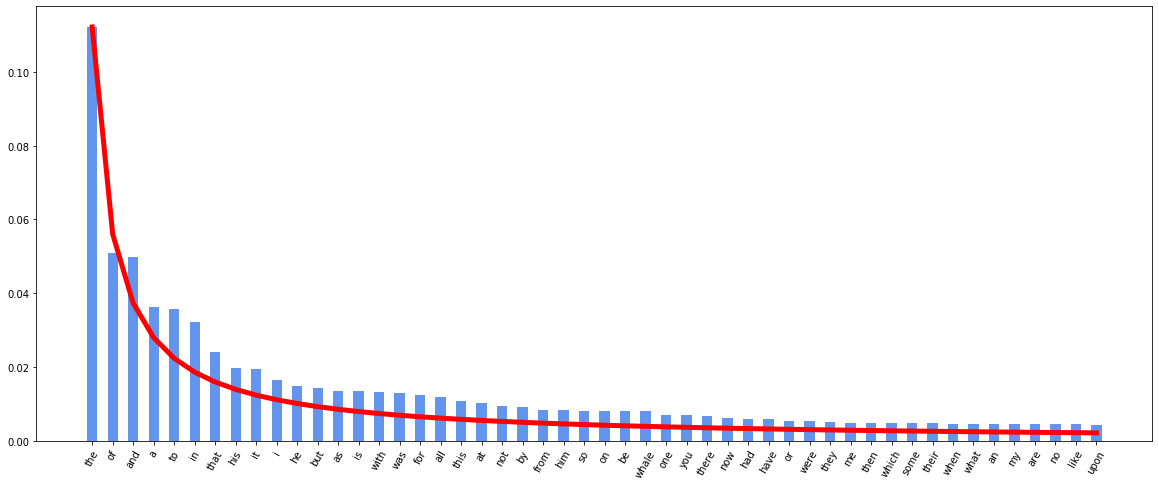

In [10]:
plt.rcParams["figure.figsize"] = (16,8)
wrds = [w[0] for w in most_common]
freq = [w[1] for w in most_common]
weights = [f/sum(freq) for f in freq]
zipf = [weights[0]/n for n in range(1,200)]

plt.rcParams["figure.figsize"] = (20,8)
plt.bar(wrds[:50], 
        weights[:50], 
        width=0.5, 
        color='cornflowerblue')
plt.plot(zipf[:50], 
         color='r', 
         linewidth=5)
plt.xticks(rotation=60)
plt.show()

### Particularities of the corpus

We remove common "stop words" in order to examine words that are particular to this text.

With a high frequency of nautical words like 'whale' (1018 occurences), 'ship' (458), 'sea' (367), and 'captain' (322), we can clearly discern the nautical theme of 'Moby Dick'.

In [11]:
# Introduce condition removing stop words
stop_words = stopwords.words('english')
filtered_words = [w for w in word_tokens if not w in stop_words]

# 
fdist_filtered = nltk.FreqDist(filtered_words)
most_common_filtered = fdist_filtered.most_common(200)
#most_common_filtered[:20]

unzip = [[ i for i, j in most_common_filtered ], 
       [ j for i, j in most_common_filtered ]] 
common_words_df = pd.DataFrame({'word': unzip[0], 'frequency': unzip[1]})
print(tabulate(common_words_df[:20], 
               headers=['Word', 'Frequency'], 
               showindex=False,
              tablefmt='pretty'))

Word       Frequency
-------  -----------
whale           1018
one              898
like             572
upon             560
ahab             508
man              488
ship             458
old              439
ye               433
would            429
though           380
sea              367
yet              344
time             324
captain          322
long             316
still            312
said             299
great            289
two              283


This word frequency distribution is distinct from other corpora in terms of _stylistics_.  

For example, while it was also written in the 19th century, the frequency ranking of non-stop words in Jane Austen's novel 'Emma' (1815) in the table below are not similar to 'Moby Dick', and unsurprisingly, are not obviously related to whaling or sailing.

In [12]:
# Function to calculate non-stop word frequency of corpus
def distinctive_words(corpus, language, word_rank_limit=200, list_length=20):
    
    # Access corpus
    path = nltk.data.find('corpora/gutenberg/{}'.format(corpus))
    raw_text = open(path, 'r').read()

    # Tokenize corpus
    tokens = word_tokenize(raw_text)
    word_tokens = [w.lower() for w in tokens if w.isalpha()] 
    print('The text contains {} tokens and {} word tokens. \n'.format(len(tokens), len(word_tokens)))
    
    # Remove stop words and calculate word frequency
    stop_words = stopwords.words('english')
    filtered_words = [w for w in word_tokens if not w in stop_words]
    fdist_filtered = nltk.FreqDist(filtered_words)
    most_common_filtered = fdist_filtered.most_common(word_rank_limit)

    # Print dataframe of words sorted by frequency
    unzip = [[ i for i, j in most_common_filtered ], 
             [ j for i, j in most_common_filtered ]] 
    common_words_df = pd.DataFrame({'word': unzip[0], 'frequency': unzip[1]})
    print(tabulate(common_words_df[:list_length], 
                   headers=['Word', 'Frequency'], 
                   showindex=False,
                   tablefmt='pretty'))
    
distinctive_words('austen-emma.txt', 'english')

The text contains 191785 tokens and 157044 word tokens. 

Word         Frequency
---------  -----------
emma               855
could              836
would              818
miss               599
must               566
harriet            496
much               484
said               483
one                447
every              435
weston             430
thing              394
think              383
well               378
elton              378
knightley          373
little             359
never              358
know               335
might              325


## Youtube